# Root Finding and Special Functions
## AEP 4380

### Problem Background
<p>
This assignment was partially about finding access to special scientific functions for numerical analysis, and partially about comparing a couple methods for root finding. 
In particular: how to access Bessel functions, useful for all sorts of physics, and then comparing Regula Falsi or the False Position Method to the method of Bisection for root finding.
</p>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special
plt.style.use('dark_background') #Don't judge me
plt.rcParams['figure.figsize'] = [20, 10]

### Solution Description
First thing's first: turns out scipy has all of the Bessel functions at the ready. It is easy enough to create a helper function which spits out evaluations of the function across a specified range for a specified number of points. What might be even nicer is to be able to specify a range and a tolerance value, and let the function figure out how many points are needed. However, in the end I think the former is sufficient.

In [4]:
def gen_plot_bessel(xmin,xmax,points,func_eval,order):
    output = [0]*points
    output_x = [0]*points
    delta = (xmax-xmin)/(points-1)
    for i in range(0,points-1):
        output_x[i] = xmin+i*delta
        output[i] = func_eval(order, output_x[i])
    output_x[points-1] = xmax
    output[points-1] = func_eval(order, xmax)
    return output_x,output    

In [5]:
#generate points for the Bessel functions of the first and second kind
num = 200
j_0 = gen_plot_bessel(0.0,20,num,sp.special.jn,0)
j_1 = gen_plot_bessel(0.0,20,num,sp.special.jn,1)
j_2 = gen_plot_bessel(0.0,20,num,sp.special.jn,2)
#The second kind blow up near zero, so I just start closeby
y_0 = gen_plot_bessel(0.75,20,num,sp.special.yn,0)
y_1 = gen_plot_bessel(0.75,20,num,sp.special.yn,1)
y_2 = gen_plot_bessel(0.75,20,num,sp.special.yn,2)

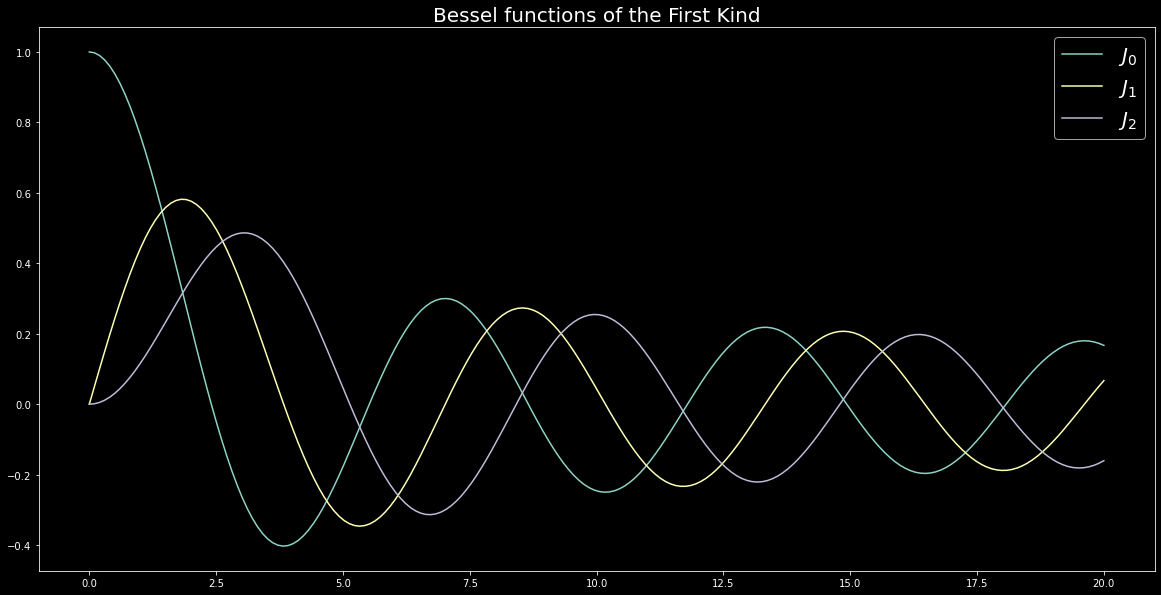

In [11]:
plt.plot(j_0[0],j_0[1]);
plt.plot(j_1[0],j_1[1]);
plt.plot(j_2[0],j_2[1]);
plt.title("Bessel functions of the First Kind",fontsize=20);
plt.legend(["$J_0$","$J_1$","$J_2$"],fontsize=20);

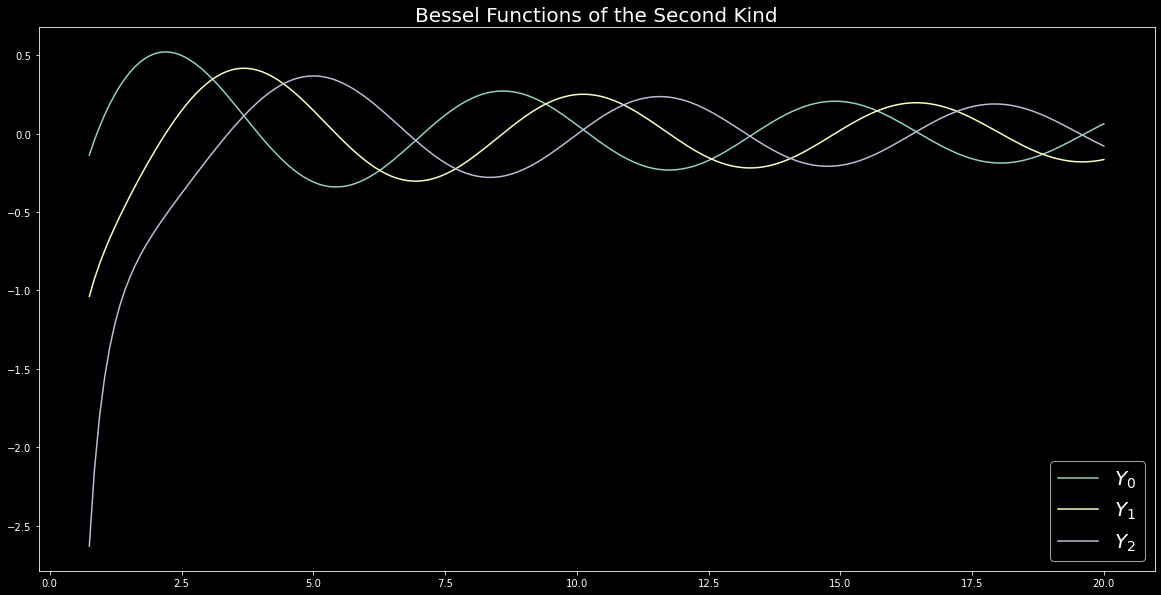

In [26]:
plt.plot(y_0[0],y_0[1])
plt.plot(y_1[0],y_1[1])
plt.plot(y_2[0],y_2[1])
plt.title("Bessel Functions of the Second Kind",fontsize=20);
plt.legend(["$Y_0$","$Y_1$","$Y_2$"],fontsize=20);

The assignment requires finding the first five smallest values of $x$ such that they satisfy the following relation:
$$J_0(x)Y_0(x) = J_2(x)Y_2(x)$$
Which is equivalent to asking for the roots of the difference between the LHS and RHS, or values of $x$ which satisfy:
$$J_0(x)Y_0(x) - J_2(x)Y_2(x) = 0$$
I first define a function which will output the result of the equation above called <code>bessel_eqn</code> and plot it along with a horizontal line to show the points that I am aiming to calculate:

In [14]:
bessel_eqn = lambda x: sp.special.jn(2,x)*sp.special.yn(2,x)-sp.special.jn(0,x)*sp.special.yn(0,x)

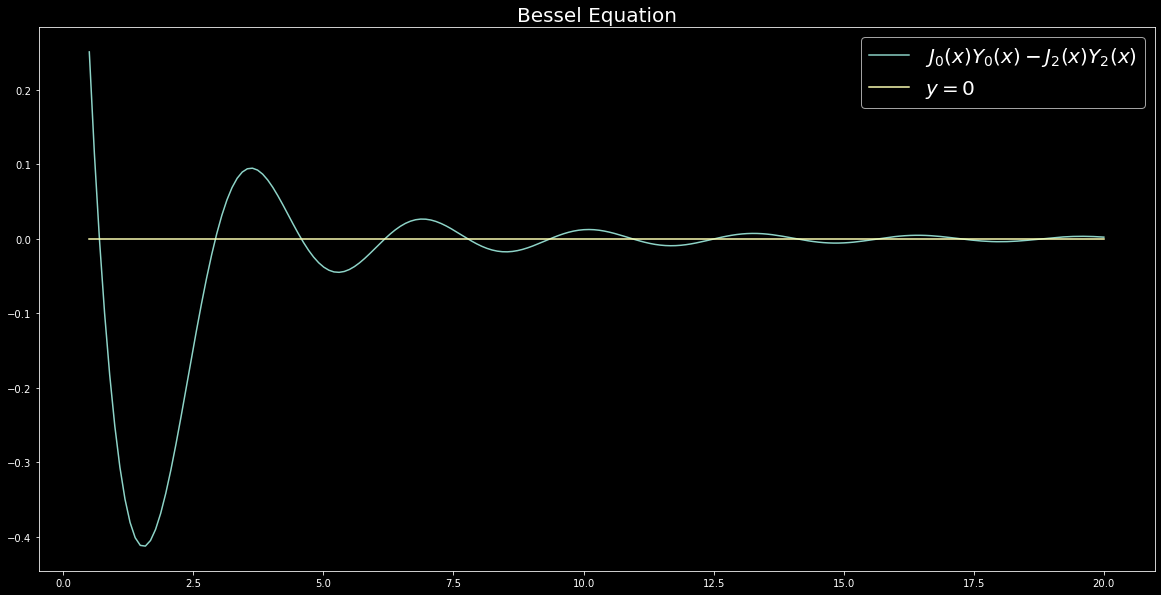

In [28]:
num=200
bessel_sub_x = np.linspace(0.5,20,num)
bessel_sub = [0]*num
for i in range(0,num):
    bessel_sub[i] = bessel_eqn(bessel_sub_x[i])
plt.plot(bessel_sub_x,bessel_sub);
plt.plot(bessel_sub_x,[0]*num);
plt.title("Bessel Equation",fontsize = 20);
plt.legend(["$J_0(x)Y_0(x) - J_2(x)Y_2(x)$","$y=0$"],fontsize=20);

Next is to define my root-finding funtions. The first method is called "bisection" and works by going halfway between two points of evaluation which straddle a root. The center evaluation will share a sign with one of the points, defining a new set of bounds which straddle the root. The process is repeated until the root is found to within whatever tolerance is defined at the outset, much like a binary search algorithm. The method takes a function as a parameter, so that it can be applied to any function. The two points which bound a root must be entered to start the algorithm. If the bounds have the same sign, then they must bound either no root or more than one root, which breaks this algorithm.

In [29]:
def root_bisection(xmin,xmax,func_eval,tol):
    num_calls = 0 #just for comparison of efficiency later
    #gather initial point evaluations
    x_low = xmin
    x_high = xmax
    low_val = func_eval(x_low)
    num_calls += 1 
    high_val = func_eval(x_high)
    num_calls += 1 
    x_mid = 0.5*(x_high+x_low)
    mid_val = func_eval(x_mid)
    num_calls += 1 
    #until within tolerance and straddling the root, continue evaluating
    while abs(mid_val)>=tol and ((low_val<=0 and high_val>0) or (low_val>0 and high_val<=0)):
        #continue search for root by making the midpoint the new high or low point
        x_mid = 0.5*(x_high+x_low)
        mid_val = func_eval(x_mid)
        num_calls += 1 
        if (mid_val>=0 and low_val>=0) or (mid_val<=0 and low_val<=0): #same sign as low value
            x_low = x_mid
            low_val = mid_val
        elif (mid_val>=0 and high_val>=0) or (mid_val<=0 and high_val<=0): #same sign as high value
            x_high = x_mid
            high_val = mid_val
    #end search for root
    return x_mid,mid_val,num_calls

The second method is called "Regula Falsi" and works by assuming the function is a straight line between the bounds which straddle a root. The zero of that line can be calculated, and then checked to see if it is, in fact, the root. If not, it serves as a new estimate for either the lower or upper bound of the root, and the algorithm repeats.

The slope of the line connecting the function $f(x)$ evaluated at $f(x_{min})$ and $f(x_{max})$ is
$$\frac{f(x_{max})-f(x_{min})}{x_{max}-x_{min}}$$
If the straight line crosses zero at $f(x_z)$, then one can start at $x_{min}$ and move to $x_z$ following that line to zero:
$$f(x_{min})+\frac{f(x_{max})-f(x_{min})}{x_{max}-x_{min}}(x_z-x_{min}) = 0$$
Rearranging to solve for $x_z$ gives our estimate for the zero crossing, or for the next bound in another call to the same function.
$$x_z = x_{min}-\frac{x_{max}-x_{min}}{f(x_{max})-f(x_{min})}f(x_{min})$$

In [32]:
def root_regula_falsi(xmin,xmax,func_eval,tol):
    num_calls = 0 #just for comparison of efficiency later
    #gather initial point evaluations
    x_low = xmin
    x_high = xmax
    low_val = func_eval(x_low)
    num_calls += 1 
    high_val = func_eval(x_high)
    num_calls += 1 
    x_mid = x_low-low_val*(x_high-x_low)/(high_val-low_val)
    mid_val = func_eval(x_mid)
    num_calls += 1 
    #until within tolerance, while straddling the root, keep searching
    while abs(mid_val)>=tol and ((low_val<=0 and high_val>0) or (low_val>0 and high_val<=0)):
        #approximate the root position by assuming there is a straight line between the bounds
        x_mid = x_low-low_val*(x_high-x_low)/(high_val-low_val)
        mid_val = func_eval(x_mid)
        num_calls += 1 
        #use new midpoint as one of the bounds, depending on its sign
        if (mid_val>=0 and low_val>=0) or (mid_val<=0 and low_val<=0): #same sign as low
            x_low = x_mid
            low_val = mid_val
        elif (mid_val>=0 and high_val>=0) or (mid_val<=0 and high_val<=0): #same sign as high
            x_high = x_mid
            high_val = mid_val
    #end search for root
    return x_mid,mid_val,num_calls    

In [98]:
def root_secant(xmin,xmax,func_eval,tol):
    num_calls = 0
    x_low = xmin
    x_high = xmax
    low_val = func_eval(x_low)
    num_calls += 1 
    high_val = func_eval(x_high)
    num_calls += 1 
    x_mid = x_low-low_val*(x_high-x_low)/(high_val-low_val)
    mid_val = func_eval(x_mid)
    num_calls += 1 
    while abs(mid_val)>=tol:
        x_mid = x_low-low_val*(x_high-x_low)/(high_val-low_val)
        mid_val = func_eval(x_mid)
        num_calls += 1 
        x_low = x_high
        low_val = high_val
        x_high = x_mid
        high_val = mid_val
    #end search for root
    return x_mid,mid_val,num_calls  

(0.694390869140625, 3.725404462695536e-08, 20) (2.9245619773864746, -2.44662948234442e-08, 23) (4.574827194213867, -2.7331677296404955e-08, 23) (6.181685638427735, -5.6046247573493524e-08, 20) (7.77337646484375, 8.398025227313033e-08, 17)


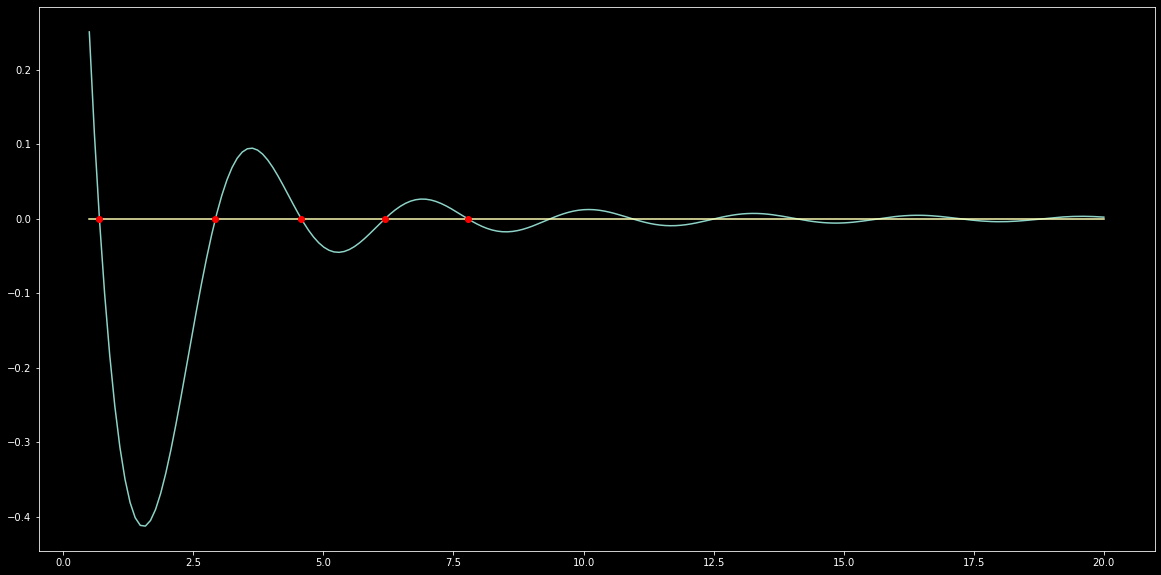

In [31]:
tolerance = 1e-7
bis_zero_1 = root_bisection(0.2,1,bessel_eqn,tolerance)
bis_zero_2 = root_bisection(2.5,3,bessel_eqn,tolerance)
bis_zero_3 = root_bisection(3,5,bessel_eqn,tolerance)
bis_zero_4 = root_bisection(5.3,7,bessel_eqn,tolerance)
bis_zero_5 = root_bisection(7,8,bessel_eqn,tolerance)
plt.plot(bessel_sub_x,bessel_sub);
plt.plot(bessel_sub_x,[0]*num);
plt.plot(bis_zero_1[0],bis_zero_1[1],'ro');
plt.plot(bis_zero_2[0],bis_zero_2[1],'ro');
plt.plot(bis_zero_3[0],bis_zero_3[1],'ro');
plt.plot(bis_zero_4[0],bis_zero_4[1],'ro');
plt.plot(bis_zero_5[0],bis_zero_5[1],'ro');
print(bis_zero_1,bis_zero_2,bis_zero_3,bis_zero_4,bis_zero_5)

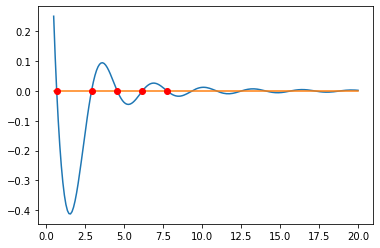

In [168]:
# tolerance = 1e-6
rf_zero_1 = root_reguli_falsi(0.2,1,bessel_eqn,tolerance)
rf_zero_2 = root_reguli_falsi(2.5,3,bessel_eqn,tolerance)
rf_zero_3 = root_reguli_falsi(3,5,bessel_eqn,tolerance)
rf_zero_4 = root_reguli_falsi(5.3,7,bessel_eqn,tolerance)
rf_zero_5 = root_reguli_falsi(7,8,bessel_eqn,tolerance)
plt.plot(bessel_sub_x,bessel_sub);
plt.plot(bessel_sub_x,[0]*num);
plt.plot(rf_zero_1[0],rf_zero_1[1],'ro');
plt.plot(rf_zero_2[0],rf_zero_2[1],'ro');
plt.plot(rf_zero_3[0],rf_zero_3[1],'ro');
plt.plot(rf_zero_4[0],rf_zero_4[1],'ro');
plt.plot(rf_zero_5[0],rf_zero_5[1],'ro');

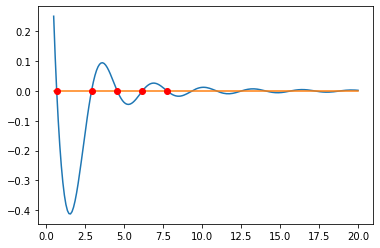

In [169]:
# tolerance = 1e-6
sec_zero_1 = root_secant(0.2,1,bessel_eqn,tolerance)
sec_zero_2 = root_secant(2.5,3,bessel_eqn,tolerance)
sec_zero_3 = root_secant(3,5,bessel_eqn,tolerance)
sec_zero_4 = root_secant(5.3,7,bessel_eqn,tolerance)
sec_zero_5 = root_secant(7,8,bessel_eqn,tolerance)
plt.plot(bessel_sub_x,bessel_sub);
plt.plot(bessel_sub_x,[0]*num);
plt.plot(sec_zero_1[0],sec_zero_1[1],'ro');
plt.plot(sec_zero_2[0],sec_zero_2[1],'ro');
plt.plot(sec_zero_3[0],sec_zero_3[1],'ro');
plt.plot(sec_zero_4[0],sec_zero_4[1],'ro');
plt.plot(sec_zero_5[0],sec_zero_5[1],'ro');

### Comparison of function calls

In [178]:
print("root\t\tbisection\treguli falsi\tsecant")
print(str(round(bis_zero_1[0],7))+"\t"+str(bis_zero_1[2])+"\t\t"+str(rf_zero_1[2])+"\t\t"+str(sec_zero_1[2]))
print(str(round(bis_zero_2[0],7))+"\t"+str(bis_zero_2[2])+"\t\t"+str(rf_zero_2[2])+"\t\t"+str(sec_zero_2[2]))
print(str(round(bis_zero_3[0],7))+"\t"+str(bis_zero_3[2])+"\t\t"+str(rf_zero_3[2])+"\t\t"+str(sec_zero_3[2]))
print(str(round(bis_zero_4[0],7))+"\t"+str(bis_zero_4[2])+"\t\t"+str(rf_zero_4[2])+"\t\t"+str(sec_zero_4[2]))
print(str(round(bis_zero_5[0],7))+"\t"+str(bis_zero_5[2])+"\t\t"+str(rf_zero_5[2])+"\t\t"+str(sec_zero_5[2]))

root		bisection	reguli falsi	secant
0.6943909	19		20		9
2.924562	22		11		7
4.5748272	22		8		8
6.1816856	19		8		9
7.7733765	16		7		7
